In [87]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.linalg import eigh
from scipy.stats import multivariate_normal as gaussian
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

## Data

In [88]:
training_data = np.load('mnist_demo/mnist_data/mnist_train_images.npy')
training_labels = np.load('mnist_demo/mnist_data/mnist_train_labels.npy')

In [89]:
set(training_labels)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [90]:
testing_data = np.load('mnist_demo/mnist_data/mnist_test_images.npy')
testing_labels = np.load('mnist_demo/mnist_data/mnist_test_labels.npy')

## Helpers

In [91]:
def calc_scatter_matrices(X, Y):
    """ See Equations (1) on p.532 of Ioffe 2006. """
    assert len(X.shape) == 2
    assert X.shape[0] == len(Y)

    unique_labels = np.unique(Y)
    labels = np.asarray(Y)

    m = X.mean(axis=0)
    N = X.shape[0]

    cov_ks = []
    m_ks = []
    n_ks = []

    for k in unique_labels:
        bool_idxs = labels == k
        X_k = X[bool_idxs]

        m_ks.append(X_k.mean(axis=0))
        n_ks.append(bool_idxs.sum())

        cov_ks.append(np.cov(X_k.T))

    n_ks = np.asarray(n_ks)
    m_ks = np.asarray(m_ks)

    m_ks_minus_m = m_ks - m
    S_b = np.matmul(m_ks_minus_m.T * (n_ks / N), m_ks_minus_m)

    S_w = np.asarray(cov_ks) * ((n_ks - 1) / N)[:, None, None]
    S_w = np.sum(S_w, axis=0)

    return S_b, S_w


In [92]:
def calc_m(X):
    """ See Fig. 2 on p.537 of Ioffe 2006. """
    assert len(X.shape) == 2
    return X.mean(axis=0)

def calc_W(S_b, S_w):
    """ See Fig. 2 on p.537 of Ioffe 2006. """
    eigenvalues, eigenvectors = eigh(S_b, S_w)
    return eigenvectors

def calc_Lambda_b(S_b, W):
    """ See Fig. 2 on p.537 of Ioffe 2006. """
    return np.matmul(np.matmul(W.T, S_b), W)

def calc_Lambda_w(S_w, W):
    """ See Fig. 2 on p.537 of Ioffe 2006. """
    return np.matmul(np.matmul(W.T, S_w), W)

def calc_n_avg(Y):
    """ This is the \"hack\" suggested in Fig 2 on p.537 of Ioffe 2006. """
    unique = np.unique(Y)
    return len(Y) / unique.shape[0]

def calc_A(n_avg, Lambda_w, W):
    """ See Fig. 2 on p.537 of Ioffe 2006. """
    Lambda_w_diagonal = Lambda_w.diagonal()  # Should be diagonal matrix.
    inv_W_T = np.linalg.inv(W.T)
    return inv_W_T * (n_avg / (n_avg - 1) * Lambda_w_diagonal) ** .5


def calc_Psi(Lambda_w, Lambda_b, n_avg):
    """ See Fig. 2 on p.537 of Ioffe 2006. """
    Lambda_w_diagonal = Lambda_w.diagonal()  # Should be diagonal matrix.
    Lambda_b_diagonal = Lambda_b.diagonal()  # Should be diagonal matrix.
    Psi = (n_avg - 1) / n_avg * Lambda_b_diagonal / Lambda_w_diagonal
    Psi -= 1 / n_avg
    Psi[Psi <= 0] = 0

    return np.diag(Psi)

def get_relevant_U_dims(Psi):
    """ See Fig. 2 on p.537 of Ioffe 2006. """
    relevant_dims = np.squeeze(np.argwhere(Psi.diagonal() != 0))
    if relevant_dims.shape == ():
        relevant_dims = relevant_dims.reshape(1,)
    return relevant_dims

def optimize_maximum_likelihood(X, labels):
    """ Performs the optimization in Fig. 2 of p.537 of Ioffe 2006.

    DESCRIPTION
     - The main model parameters are `m`, `A`, and `Psi`.
     - However, to improve the performance (speed and numerical stability)
        of the plda.Model object,
        inv_A and relevant_U_dims are also returned here.

    ADDITIONAL NOTES
     Be sure to test that np.cov(X.T) is full rank before running this.

     Recall that there are 4 \"spaces\":
      'D' (data) <---> 'X' (preprocessed) <---> 'U' (latent) <---> 'U_model'

    ARGUMENTS
     X  (numpy.ndarray), shape=(n_data, n_dimensions)
       - Data in statistics format, i.e. row-wise.

     labels  (list or numpy.ndarray), length=X.shape[0]
       - Labels for the data in `X`.
       - Must be sorted in the same order as `X`.

    RETURNS
     m  (numpy.ndarray), shape=X.shape[-1]
       - The mean of the row vectors in X.
       - This is the prior mean fitted via maximum likelihood.

     A  (numpy.ndarray), shape=(X.shape[-1], X.shape[-1])
       - Transformation from X space to the latent U space.

     Psi  (numpy.ndarray), shape=(X.shape[-1], X.shape[-1])
       - The covariance matrix of the prior distribution on
          the category means in U space.

     relevant_U_dims  (numpy.ndarray), shape=(len(np.unique(labels)) - 1,)
       - The \"effective\" latent dimensions,
          i.e. the ones that are actually used by the model.

     inv_A  (numpy.ndarray), shape=A.shape
       - The inverse of the matrix A.
       - Transformation from the latent U space to the X space.
    """
    assert len(X.shape) == 2
    assert X.shape[0] == len(labels)

    m = X.mean(axis=0)

    S_b, S_w = calc_scatter_matrices(X, labels)
    W = calc_W(S_b, S_w)

    Lambda_b = calc_Lambda_b(S_b, W)
    Lambda_w = calc_Lambda_w(S_w, W)
    n_avg = calc_n_avg(labels)

    A = calc_A(n_avg, Lambda_w, W)
    inv_A = np.linalg.inv(A)

    Psi = calc_Psi(Lambda_w, Lambda_b, n_avg)
    relevant_U_dims = get_relevant_U_dims(Psi)

    return m, A, Psi, relevant_U_dims, inv_A



## Calculate

In [93]:
data=training_data
labels=training_labels
n_principal_components=2

#### Scatte matrices (not needed if n_principal components set)

In [94]:
S_b, S_w = calc_scatter_matrices(data, labels)
matrix_rank = np.linalg.matrix_rank(S_w)

In [95]:
S_b

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [96]:
S_w

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [97]:
matrix_rank

190

well set it to n_components not to overlearn

In [98]:
matrix_rank=n_principal_components

#### PCA

In [99]:
pca = PCA(n_components=matrix_rank)
pca.fit(data)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

### transform

In [100]:
# X = self.transform(data, from_space='D', to_space='X')

X=pca.transform(data)

In [101]:
X.shape

(200, 2)

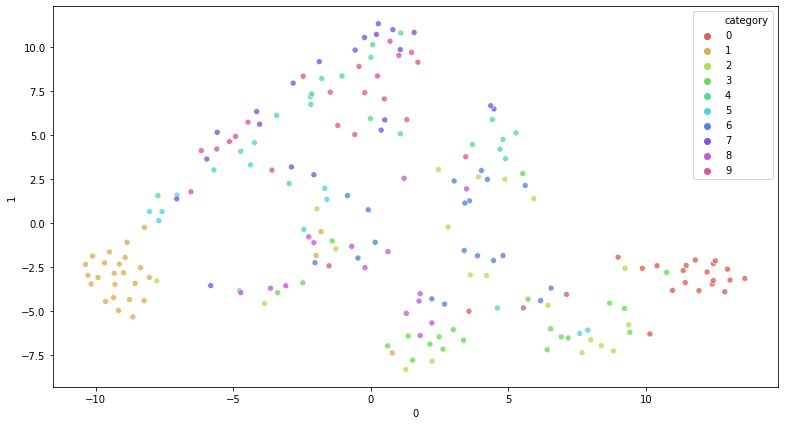

In [102]:
#plot transformed features
#use tsne to get 2 dim
X_tsne = TSNE(n_components=2).fit_transform(X)

df_tsne = pd.DataFrame(X_tsne)
df_tsne.columns = [str(c) for c in df_tsne.columns]
df_tsne['category'] = training_labels

plt.figure(figsize=(13, 7))
ax = sns.scatterplot(
    x="0", y="1",
    hue="category",
#     palette=['green', 'orange'],
        palette=sns.color_palette("hls", 10),
    data=df_tsne,
    legend="full",
    alpha=0.8
)
plt.setp(ax.get_legend().get_texts(), fontsize='10')  # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='10')  # for legend title
plt.show()

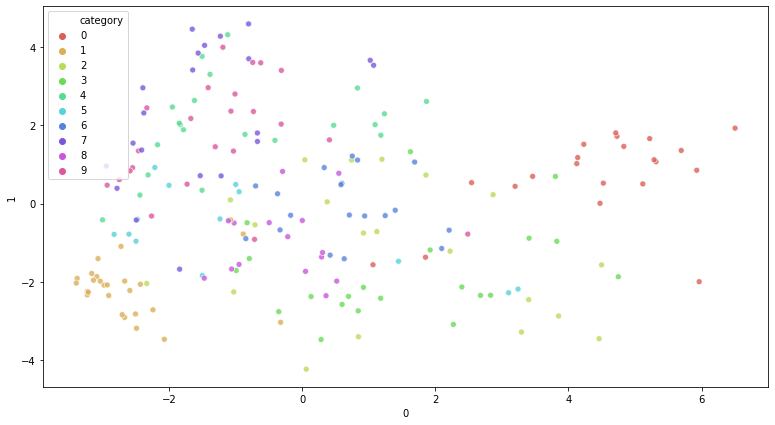

In [103]:
#plot pca features, if only 2-dim
pca_2dim = PCA(n_components=2)
pca_2dim.fit(data)
X_2dim=pca_2dim.transform(data)
df_x2dim=pd.DataFrame(X_2dim)
df_x2dim['category']=labels

plt.figure(figsize=(13, 7))
ax = sns.scatterplot(
    x=0, y=1,
    hue="category",
#     palette=['green', 'orange'],
        palette=sns.color_palette("hls", 10),
    data=df_x2dim,
    legend="full",
    alpha=0.8
)
plt.setp(ax.get_legend().get_texts(), fontsize='10')  # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='10')  # for legend title
plt.show()

#### learn params

In [104]:
m, A, Psi, relevant_U_dims, inv_A = optimize_maximum_likelihood(X, labels)

In [105]:
m

array([-1.5541912e-07, -2.5749208e-07], dtype=float32)

In [108]:
A

array([[-0.51181111, -1.25866433],
       [-1.17934279,  0.38279653]])

Text(-1.7621300593422637, 0.535915139609657, 'a2')

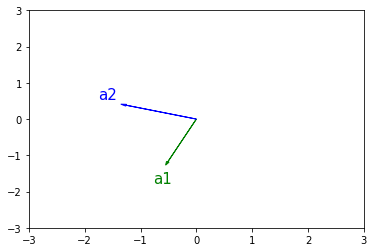

In [136]:
#plot A
fig, ax = plt.subplots()
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
ax.arrow(0, 0, *A.T[0,:], head_width=0.05, head_length=0.1, color='green')
ax.text(*(A[:,0]*1.5), 'a1', fontsize=15, color='green')
ax.arrow(0, 0, *A.T[1,:], head_width=0.05, head_length=0.1, color='blue')
ax.text(*(A[:,1]*1.4), 'a2', fontsize=15, color='blue')

In [137]:
Psi

array([[1.53620848, 0.        ],
       [0.        , 2.17729025]])

In [138]:
relevant_U_dims

array([0, 1], dtype=int64)

In [139]:
inv_A

array([[-0.2278122 , -0.74906397],
       [-0.70185765,  0.30459214]])

Text(-1.3845307609117787, 0.42107618112187345, 'a2')

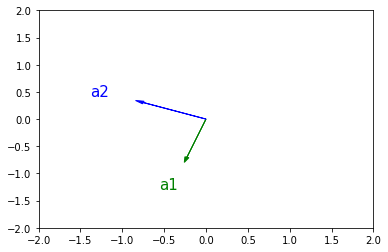

In [140]:
#plot inv A
fig, ax = plt.subplots()
ax.set_xlim([-2,2])
ax.set_ylim([-2,2])
ax.arrow(0, 0, *inv_A.T[0,:], head_width=0.05, head_length=0.1, color='green')
ax.text(*(A[:,0]*1.1), 'a1', fontsize=15, color='green')
ax.arrow(0, 0, *inv_A.T[1,:], head_width=0.05, head_length=0.1, color='blue')
ax.text(*(A[:,1]*1.1), 'a2', fontsize=15, color='blue')

#### transfrom X from space X to U_model

In [141]:
#from X -> U
x_in_u=np.matmul(X - m, inv_A.T)

U_model=x_in_u[..., relevant_U_dims]
U_model.round(3)[0]

array([ 0.777, -1.466])

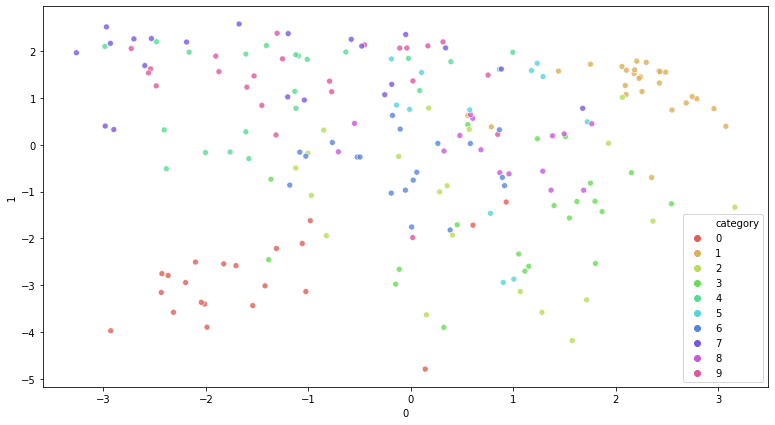

In [143]:
#U_dim
df_udim_model=pd.DataFrame(U_model)
df_udim_model['category']=labels

plt.figure(figsize=(13, 7))
ax = sns.scatterplot(
    x=0, y=1,
    hue="category",
#     palette=['green', 'orange'],
        palette=sns.color_palette("hls", 10),
    data=df_udim_model,
    legend="full",
    alpha=0.8
)
plt.setp(ax.get_legend().get_texts(), fontsize='10')  # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='10')  # for legend title
plt.show()

#### get prior params

In [113]:
cov_diag = Psi.diagonal()[relevant_U_dims]
mean = np.zeros(relevant_U_dims.shape)

prior_params= {'mean': mean, 'cov_diag': cov_diag}
mean

array([0., 0.])

In [25]:
cov_diag

array([0.07600873, 0.74136588, 1.65184094, 2.49808835, 3.43668892])

#### get posterior params

In [26]:
labels = np.asarray(labels)
prior_cov_diagonal = prior_params['cov_diag']

cov_diags = []
means = []
categories = []

for k in np.unique(labels):
#     print(k)
    bool_idxs = labels == k
    U_model_k = U_model[bool_idxs]
    n_k = bool_idxs.sum()

    cov_diag = prior_cov_diagonal / (1 + n_k * prior_cov_diagonal)
    mean = U_model_k.sum(axis=0) * cov_diag

    cov_diags.append(cov_diag)
    means.append(mean)
    categories.append(k)

    #add them to dict
posterior_params = dict()
for label, mean, cov_diag in zip(categories, means, cov_diags):
    category_params = dict()
    category_params['mean'] = mean
    category_params['cov_diag'] = cov_diag

    posterior_params[label] = category_params

In [27]:
posterior_params

{0: {'mean': array([-0.02610609, -0.20151194,  0.94472261, -1.59140712, -4.4639341 ]),
  'cov_diag': array([0.0292771 , 0.04474501, 0.04628476, 0.0467283 , 0.04696825])},
 1: {'mean': array([ 0.12092927, -1.5122725 , -1.42832666, -0.18380136,  1.28495954]),
  'cov_diag': array([0.02553862, 0.03656459, 0.03758638, 0.03787835, 0.03803586])},
 2: {'mean': array([ 0.05348059,  0.24555959, -0.99771235,  0.02933849, -1.10750724]),
  'cov_diag': array([0.0301601 , 0.0468409 , 0.048531  , 0.04901887, 0.04928299])},
 3: {'mean': array([ 0.24354613,  1.46989316, -1.55762291, -1.75788874,  0.56731153]),
  'cov_diag': array([0.0292771 , 0.04474501, 0.04628476, 0.0467283 , 0.04696825])},
 4: {'mean': array([0.0980901 , 0.41656326, 1.3948712 , 1.0761109 , 1.04384135]),
  'cov_diag': array([0.0292771 , 0.04474501, 0.04628476, 0.0467283 , 0.04696825])},
 5: {'mean': array([ 0.00968059, -1.03285555, -0.28146409, -0.22572721, -0.13078835]),
  'cov_diag': array([0.03823158, 0.06969194, 0.07350031, 0.0746

#### get posterior_predictive_params

In [28]:
posterior_predictive_params = posterior_params.copy()

for k, k_params in posterior_predictive_params.items():
    k_params['cov_diag'] += 1

In [29]:
posterior_predictive_params

{0: {'mean': array([-0.02610609, -0.20151194,  0.94472261, -1.59140712, -4.4639341 ]),
  'cov_diag': array([1.0292771 , 1.04474501, 1.04628476, 1.0467283 , 1.04696825])},
 1: {'mean': array([ 0.12092927, -1.5122725 , -1.42832666, -0.18380136,  1.28495954]),
  'cov_diag': array([1.02553862, 1.03656459, 1.03758638, 1.03787835, 1.03803586])},
 2: {'mean': array([ 0.05348059,  0.24555959, -0.99771235,  0.02933849, -1.10750724]),
  'cov_diag': array([1.0301601 , 1.0468409 , 1.048531  , 1.04901887, 1.04928299])},
 3: {'mean': array([ 0.24354613,  1.46989316, -1.55762291, -1.75788874,  0.56731153]),
  'cov_diag': array([1.0292771 , 1.04474501, 1.04628476, 1.0467283 , 1.04696825])},
 4: {'mean': array([0.0980901 , 0.41656326, 1.3948712 , 1.0761109 , 1.04384135]),
  'cov_diag': array([1.0292771 , 1.04474501, 1.04628476, 1.0467283 , 1.04696825])},
 5: {'mean': array([ 0.00968059, -1.03285555, -0.28146409, -0.22572721, -0.13078835]),
  'cov_diag': array([1.03823158, 1.06969194, 1.07350031, 1.0746

## Predict on new data

#### transform from D to U_model

In [144]:
data_temp=pca.transform(testing_data)
data_temp=np.matmul(data_temp - m, inv_A.T)
testing_data_transformed=data_temp[..., relevant_U_dims]

In [145]:
testing_data_transformed.shape

(100, 2)

In [146]:
testing_data_transformed[0]

array([-1.57349984,  1.57966457])

In [147]:
testing_data_transformed[1]

array([ 2.13383421, -1.73896961])

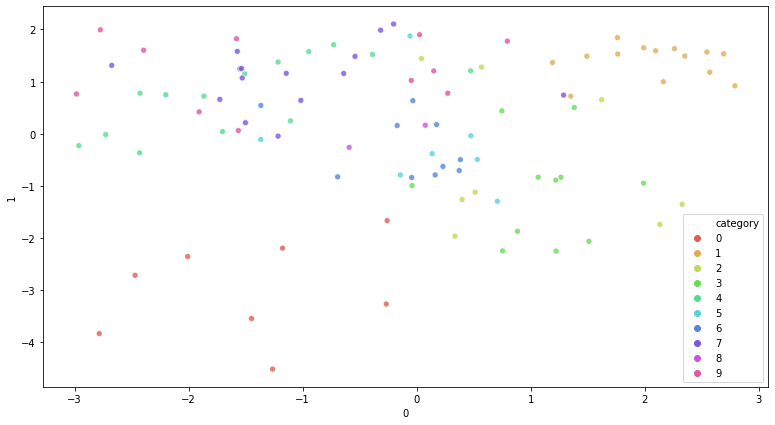

In [148]:
#testing_data_transformed
df_testing_data_transformed=pd.DataFrame(testing_data_transformed)
df_testing_data_transformed['category']=testing_labels

plt.figure(figsize=(13, 7))
ax = sns.scatterplot(
    x=0, y=1,
    hue="category",
#     palette=['green', 'orange'],
        palette=sns.color_palette("hls", 10),
    data=df_testing_data_transformed,
    legend="full",
    alpha=0.8
)
plt.setp(ax.get_legend().get_texts(), fontsize='10')  # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='10')  # for legend title
plt.show()

#### calculate logprobs per category

In [34]:
def calc_logp_posterior_predictive( U_model, category):
    mean = posterior_predictive_params[category]['mean']
    cov_diag = posterior_predictive_params[category]['cov_diag']

    return gaussian(mean, np.diag(cov_diag)).logpdf(U_model)

In [35]:
logpps_by_category = []
K =  [k for k in posterior_params.keys()]

for k in K:
    logpps_k = calc_logp_posterior_predictive(testing_data_transformed, k)
    logpps_by_category.append(logpps_k)

logpps_by_category = np.stack(logpps_by_category, axis=-1)

logps = logpps_by_category
K=np.asarray(K)

In [36]:
logps[1]

array([-14.88411373, -11.90863456,  -7.49689085, -14.8059941 ,
       -18.05136492,  -9.49470114, -13.79785348, -20.78909346,
       -12.87089219, -20.49892828])

#### get highest logprob

In [37]:
predictions = K[np.argmax(logps, axis=-1)]

In [38]:
predictions

array([7, 2, 1, 0, 4, 1, 9, 4, 2, 7, 0, 5, 4, 0, 1, 5, 4, 7, 2, 9, 7, 6,
       5, 2, 9, 0, 7, 4, 0, 1, 3, 1, 3, 5, 9, 2, 9, 1, 2, 1, 1, 9, 9, 5,
       1, 2, 1, 5, 9, 4, 6, 2, 4, 5, 5, 2, 4, 1, 4, 5, 4, 2, 9, 8, 9, 9,
       5, 4, 3, 0, 7, 0, 2, 8, 1, 9, 3, 9, 8, 7, 4, 6, 2, 9, 8, 9, 9, 2,
       4, 1, 3, 6, 9, 3, 1, 4, 1, 8, 6, 4], dtype=uint8)

## Visualize

#### original testing data

In [39]:
def plot_tsne(x, y, n_components=2):
    X_tsne = TSNE(n_components=2).fit_transform(x)

    df_tsne = pd.DataFrame(X_tsne)
    df_tsne.columns = [str(c) for c in df_tsne.columns]
    df_tsne['category'] = y

    plt.figure(figsize=(12, 8))
    ax = sns.scatterplot(
        x="0", y="1",
        hue="category",
#         palette=['green', 'orange'],
        palette=sns.color_palette("hls", 10),
        data=df_tsne,
        legend="full",
        alpha=0.7
    )
    plt.setp(ax.get_legend().get_texts(), fontsize='22')  # for legend text
    plt.setp(ax.get_legend().get_title(), fontsize='25')  # for legend title

#### original testing data

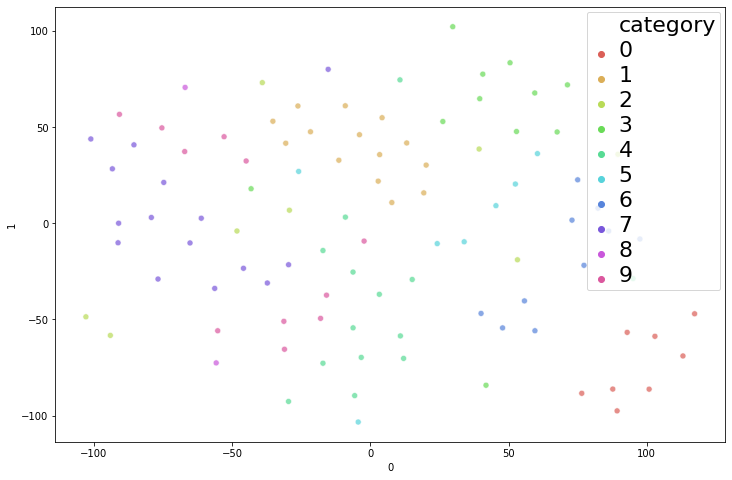

In [40]:
plot_tsne(testing_data, testing_labels)

#### transformed testing data

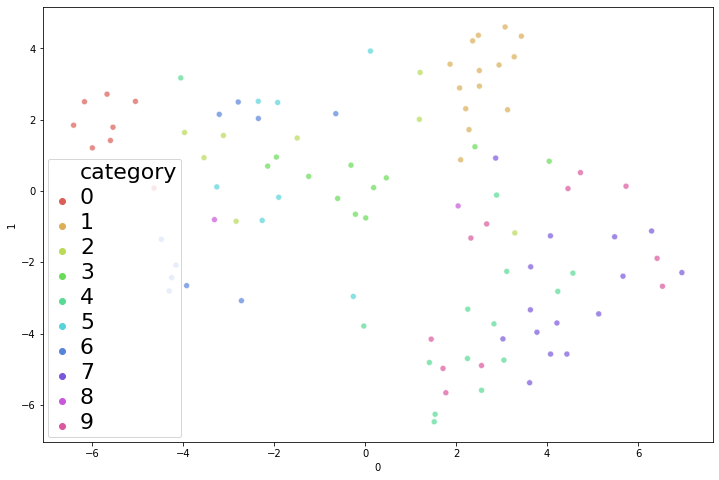

In [41]:
plot_tsne(testing_data_transformed, testing_labels)

#### Compare with LDA

In [42]:
clf = LinearDiscriminantAnalysis(n_components=5)
clf.fit(training_data, training_labels)

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LinearDiscriminantAnalysis(n_components=5, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [43]:
lda_transformed_testdata=clf.transform(testing_data)

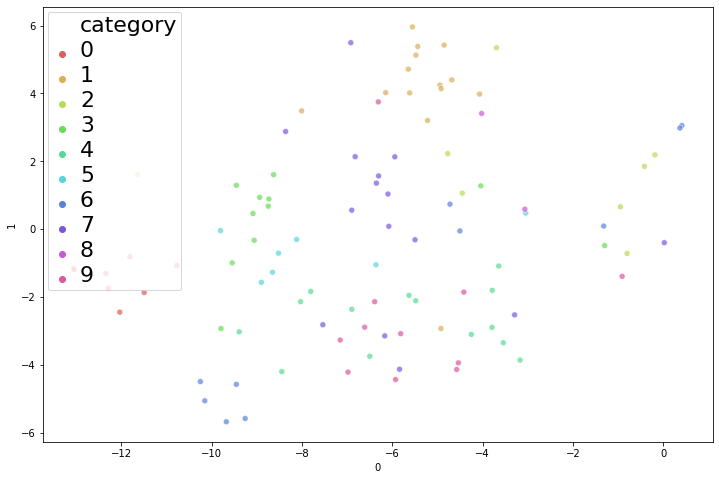

In [44]:
plot_tsne(lda_transformed_testdata, testing_labels)

In [45]:
testing_data.shape

(100, 784)

In [46]:
testing_data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [47]:
training_data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [48]:
training_data.shape

(200, 784)

## my testing

In [53]:
def scatter_mat(x, y):
    m=x.mean(axis=0)
    unique_labels=np.unique(y)
    
    m_ks=[]
    n_ks=[]
    cov_ks=[]
    for label in unique_labels:
        bool_idx=y==label
        class_x=x[bool_idx]
        m_ks.append(class_x.mean(axis=0))
        n_ks.append(bool_idx.sum())
        cov_ks.append(np.cov(class_x.T))
    m_ks=np.array(m_ks)
    n_ks=np.array(n_ks)
    cov_ks=np.array(cov_ks)
    m_ks_minus_m=m_ks-m
    sb=((n_ks*m_ks_minus_m.T)@m_ks_minus_m)/len(x)
    sw=cov_ks*((n_ks-1)/len(x))[:,None, None]
    sw=sw.sum(axis=0)
    return sb, sw

In [54]:
scatter_mat(x, y)

(array([[0.25  , 0.625 , 0.5   ],
        [0.625 , 1.5625, 1.25  ],
        [0.5   , 1.25  , 1.    ]]),
 array([[ 0.5  ,  0.5  , -0.25 ],
        [ 0.5  ,  0.625, -0.875],
        [-0.25 , -0.875,  3.25 ]]))

In [ ]:
(y==1).sum()

In [56]:
sb, sw=calc_scatter_matrices(x,y)

In [57]:
sb

array([[0.25  , 0.625 , 0.5   ],
       [0.625 , 1.5625, 1.25  ],
       [0.5   , 1.25  , 1.    ]])

In [58]:
sw

array([[ 0.5  ,  0.5  , -0.25 ],
       [ 0.5  ,  0.625, -0.875],
       [-0.25 , -0.875,  3.25 ]])

In [153]:
eigenvalues, eigenvectors=eigh(sb, sw)
eigenvalues

array([-1.00000000e+00,  1.82826856e-17,  1.17693460e+16])

In [154]:
eigenvectors

array([[ 9.19238805e-01, -2.05060966e+00, -9.76379551e+07],
       [-7.07106766e-01,  7.07106780e-01,  1.08486617e+08],
       [ 4.24264072e-01,  1.41421357e-01,  2.16973234e+07]])

In [168]:
x.mean(axis=0)

array([2.5 , 4.25, 3.5 ])

In [169]:
#m, A, Psi, relevant_U_dims, inv_A
optimize_maximum_likelihood(x, y)

(array([2.5 , 4.25, 3.5 ]),
 array([[ 2.34660440e-09, -1.00000000e+00,  1.85307065e-09],
        [-4.99999998e-01, -1.00000000e+00,  4.63267665e-09],
        [ 2.50000000e+00,  5.00000006e-01,  3.70614119e-09]]),
 array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 7.28041361e+16]]),
 array([2], dtype=int64),
 array([[ 6.49999993e-01, -4.99999989e-01,  3.00000002e-01],
        [-1.45000000e+00,  4.99999999e-01,  1.00000001e-01],
        [-2.42840174e+08,  2.69822416e+08,  5.39644832e+07]]))

In [157]:
n=len(x)/len(np.unique(y))
n

2.0

In [158]:
lambda_b=eigenvectors.T@sb@eigenvectors

In [159]:
lambda_w=eigenvectors.T@sw@eigenvectors

In [177]:
A=np.linalg.inv(eigenvectors.T)*((n/(n-1))*lambda_w.diagonal())**.5
# Lambda_w_diagonal = Lambda_w.diagonal()  # Should be diagonal matrix.
# inv_W_T = np.linalg.inv(W.T)
# return inv_W_T * (n_avg / (n_avg - 1) * Lambda_w_diagonal) ** .5

In [178]:
A

array([[ 2.34660440e-09, -1.00000000e+00,  1.85307065e-09],
       [-4.99999998e-01, -1.00000000e+00,  4.63267665e-09],
       [ 2.50000000e+00,  5.00000006e-01,  3.70614119e-09]])

In [189]:
psi=((n-1)/n)*(lambda_b.diagonal()/lambda_w.diagonal())-1/n
psi[psi<0]=0
psi

array([0.00000000e+00, 0.00000000e+00, 7.28041361e+16])

In [190]:
np.diag(psi)

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 7.28041361e+16]])

In [ ]:
def calc_scatter_matrices(X, Y):
    """ See Equations (1) on p.532 of Ioffe 2006. """
    assert len(X.shape) == 2
    assert X.shape[0] == len(Y)

    unique_labels = np.unique(Y)
    labels = np.asarray(Y)

    m = X.mean(axis=0)
    N = X.shape[0]

    cov_ks = []
    m_ks = []
    n_ks = []

    for k in unique_labels:
        bool_idxs = labels == k
        X_k = X[bool_idxs]

        m_ks.append(X_k.mean(axis=0))
        n_ks.append(bool_idxs.sum())

        cov_ks.append(np.cov(X_k.T))

    n_ks = np.asarray(n_ks)
    m_ks = np.asarray(m_ks)

    m_ks_minus_m = m_ks - m
    S_b = np.matmul(m_ks_minus_m.T * (n_ks / N), m_ks_minus_m)

    S_w = np.asarray(cov_ks) * ((n_ks - 1) / N)[:, None, None]
    S_w = np.sum(S_w, axis=0)

    return S_b, S_w


In [51]:
x=np.array([[1,2,3],
           [3,4,2],
           [3,6,2],
           [3,5,7]])
y=np.array([0,0,1,1])

In [52]:
calc_scatter_matrices(x,y)

(array([[0.25  , 0.625 , 0.5   ],
        [0.625 , 1.5625, 1.25  ],
        [0.5   , 1.25  , 1.    ]]),
 array([[ 0.5  ,  0.5  , -0.25 ],
        [ 0.5  ,  0.625, -0.875],
        [-0.25 , -0.875,  3.25 ]]))